In [ ]:
import cv2, os, glob
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_yen
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold, threshold_minimum
import skimage.measure as measure
from scipy.stats import linregress
from scipy.optimize import curve_fit

# Splitting videos into images

In [ ]:
#Step 1: split into images

#find videos
print(f'Current directory: {os.getcwd()}') #troubleshooting, find current directory

path_to_videos = glob.glob(os.path.join('Videos','*.avi')) #issue may be encountered where the video type is .mp4 instead of .avi
print(path_to_videos, '-'*10, sep = '\n') #troubleshooting step, to ensure video paths are extracted correctly

#create required directories
def makefolders(path):
    folder = os.path.split(path) #create folders for extracting all images
    folder = os.path.splitext(folder[-1])
    folder_create = os.path.join('Videos',folder[0])
    if os.path.exists(folder_create) == False: #checking if the folder already exists, and if it does not, create a new folder with the video name as its name
        os.mkdir(folder_create)
    else:
        pass
    return folder_create

#navigate into folder for the image and save images
def saveimages(path, dir_name):
    cam = cv2.VideoCapture(path) #access the video. Idk how this actually works
    video_index = []
    count, success = 0, True
    while success:
        success, image = cam.read() #access next image of the video
        if not cam.isOpened():
            print(f"Error: Could not open video file {path}")
        os.chdir(dir_name) #change directory so that it saves into the directory that we want to save into
        if success:
            folder = os.path.split(dir_name)
            frame = f'{folder[-1]}_frame_{count:02}.jpg'
            video_index.append(frame)
            if os.path.exists(frame) == False:
                cv2.imwrite(frame, image)
                count+=1
            else:
                print(f'Image {folder[-1]}_frame_{count:02}.jpg already exists, skipping save')
                count+=1
        else:
            print('Image failed to save')
        os.chdir(os.path.join('..','..')) #exit directory for that particular video folder
    cam.release()
    print(f'Current directory: {os.getcwd()} \n Completed {path}\n--------------------')
    return video_index

In [ ]:
#this extracts images by calling the functions defined above
video_indexes, folder_indexes = [],[]
vf_dict = {}
for path in path_to_videos:
    dir_name = makefolders(path)
    folder_indexes.append(dir_name)
    img_names = saveimages(path, dir_name)
    video_indexes.append(img_names)
    vf_dict[os.path.split(dir_name)[-1]] = img_names #add new terms to dictionary

# Old code

In [ ]:
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, 'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                total_fluorescence.append(img_gray.sum()) #sum up signal inside individual frames and append into total_fluorascence

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function


def histogrammer(video1, i): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames. 
    name = os.path.split(video_folders[i]) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1
    
    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.
    
    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    # plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output
    

#calling of the functions to do all the dirty work
for i, folder in enumerate(video_folders): #for index inside folder, count the number of folders inside the path video_folders
    video1 = extract_fluorescenceData(folder) #isolate the single videos, split into frames, change to grayscale, give add sum(fluorescence) per frame and save as video1
    all_video_values.append(video1) #append numpy total_fluorescence of this video from each iteration into all_video_values. Placed here instead of extract_fluorescenceData function if not next time i call it, it will append junk
    histogrammer(video1, i) #store the list of fluorescence signals as video1 and plot histogram

# Crop and Plot

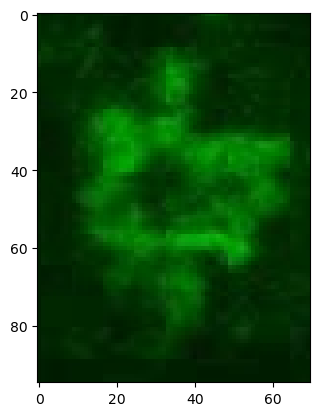

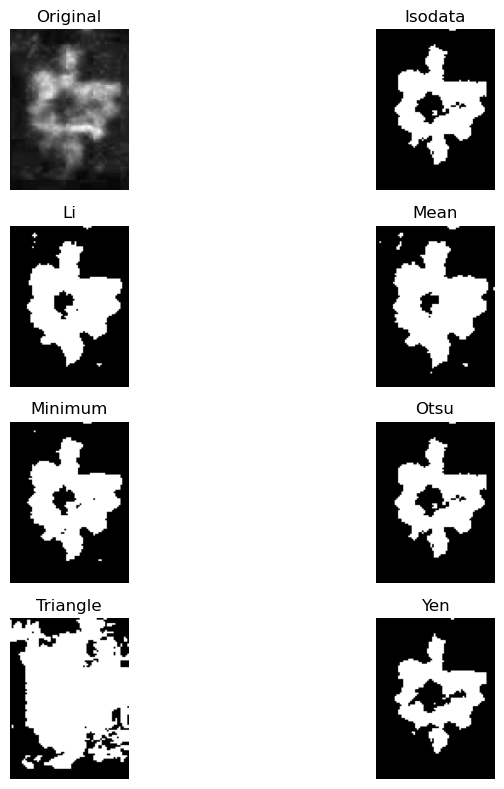

In [5]:
#here, testing on a single image for cropping
video = {'1ugDNA_drug10uM_5min45min_1': (625,740, 600,720)}

img_path = '1ugDNA_drug10uM_5min45min_1_frame_01.jpg'
img = plt.imread(os.path.join('Videos',list(video.keys())[0], img_path))
img = img[695:790, 655:725]

plt.imshow(img)

img_grey = rgb2gray(img)
plt.show()

fig, ax = try_all_threshold(img_grey, figsize=(10, 8), verbose=False)
plt.show()

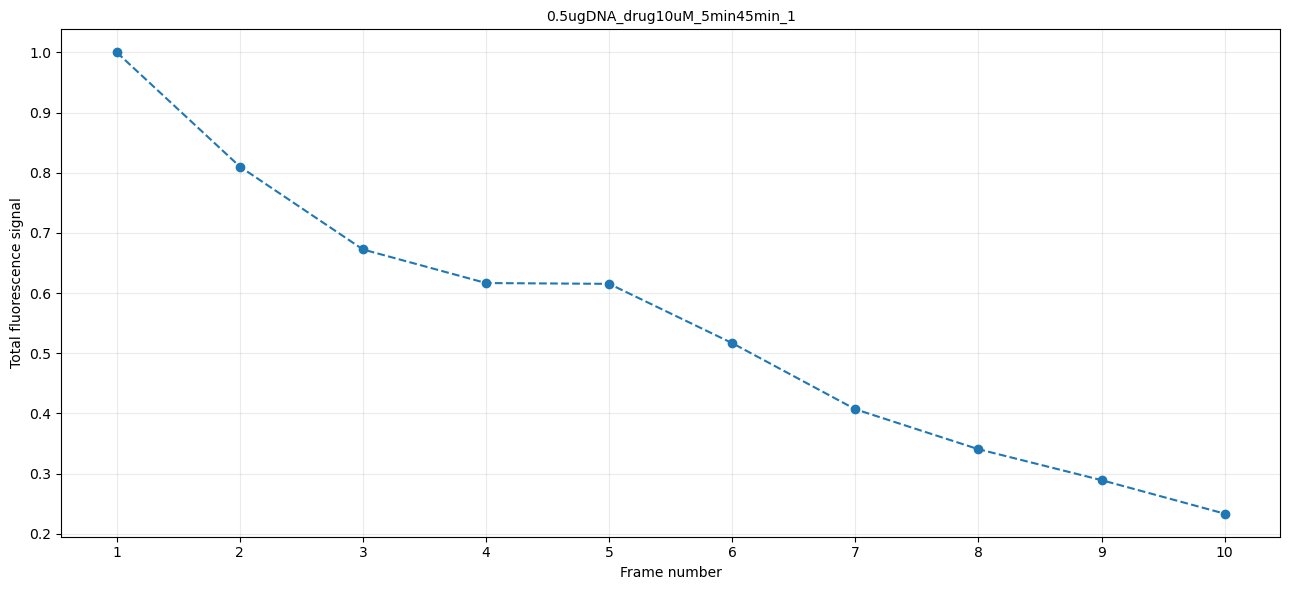

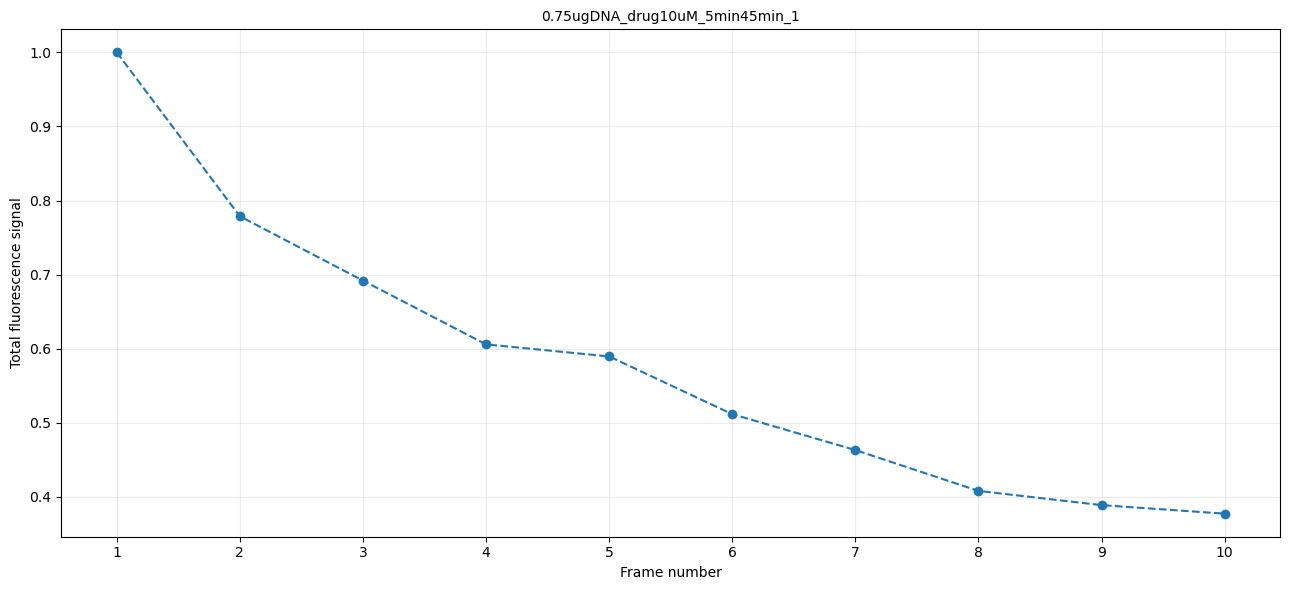

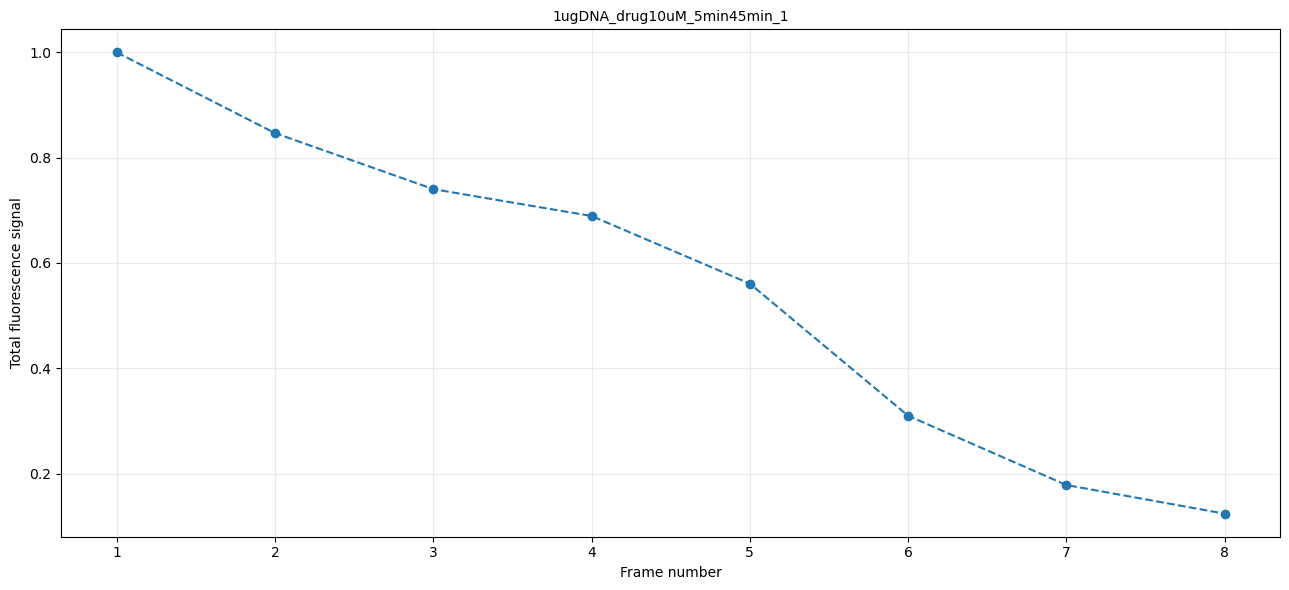

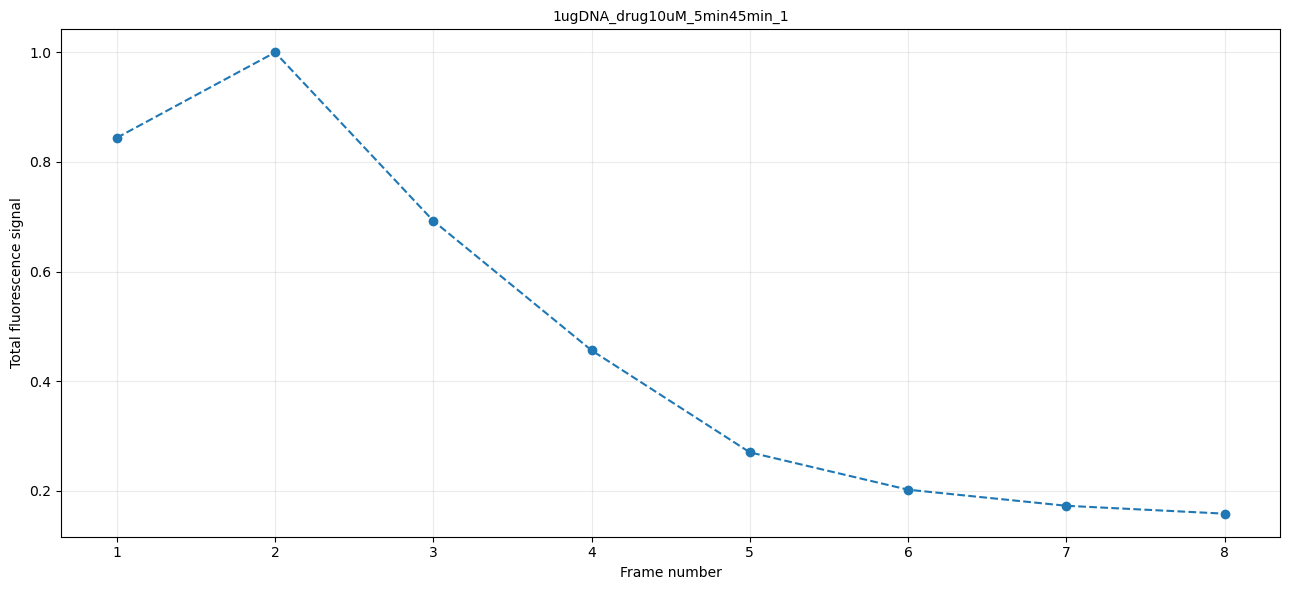

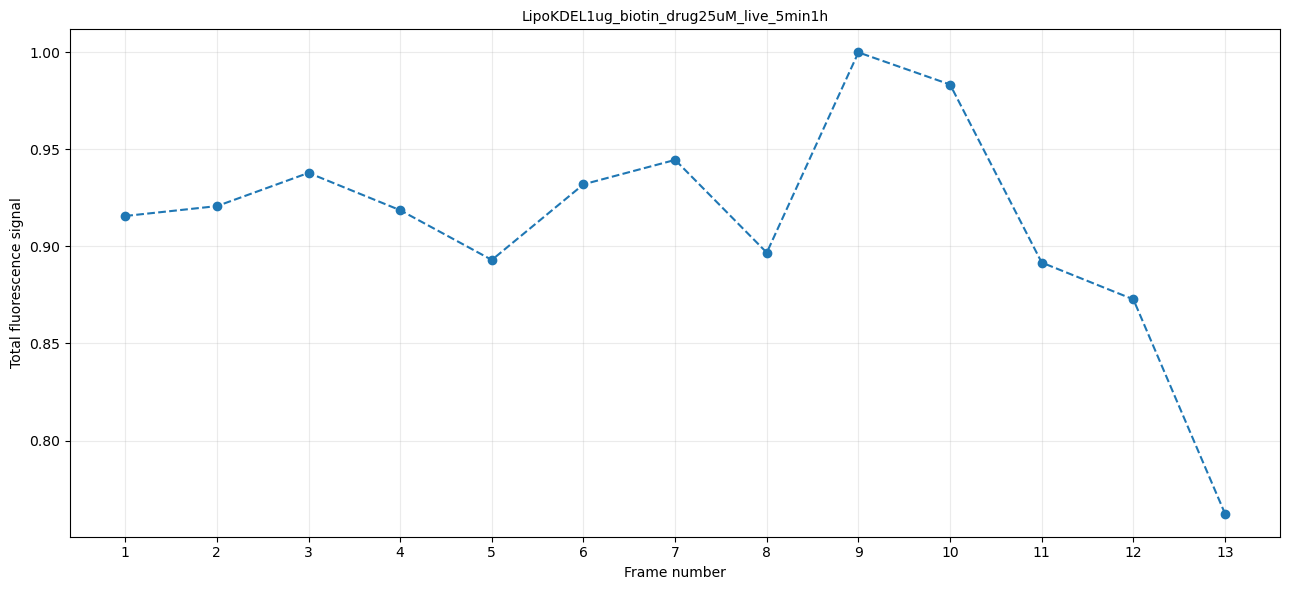

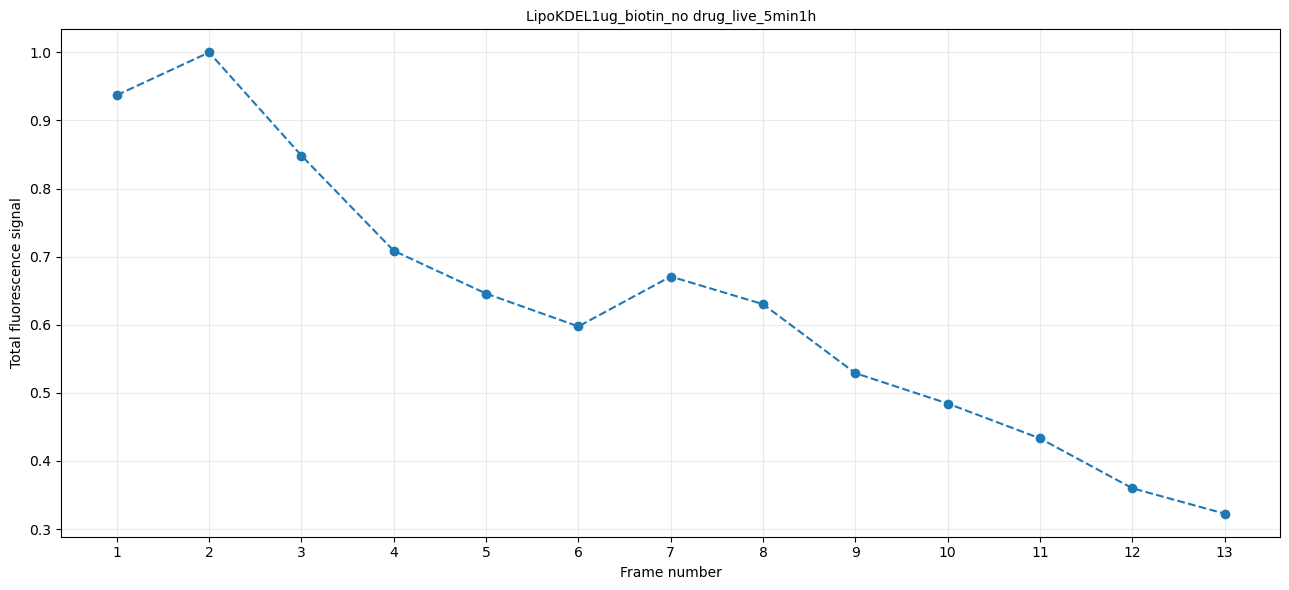

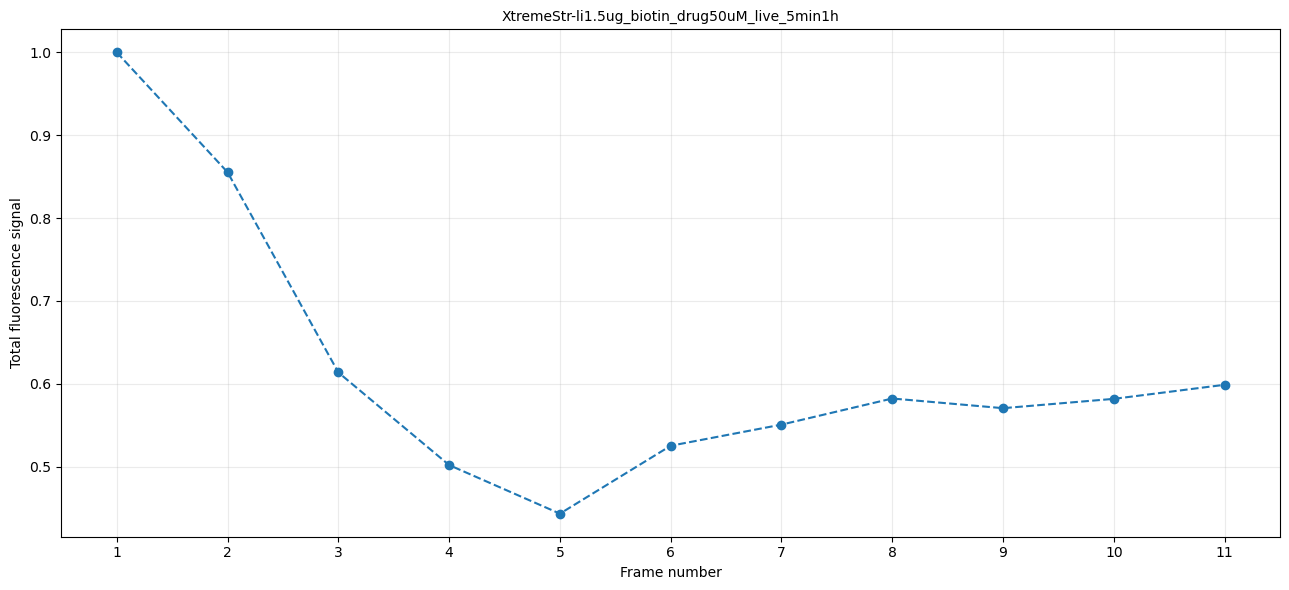

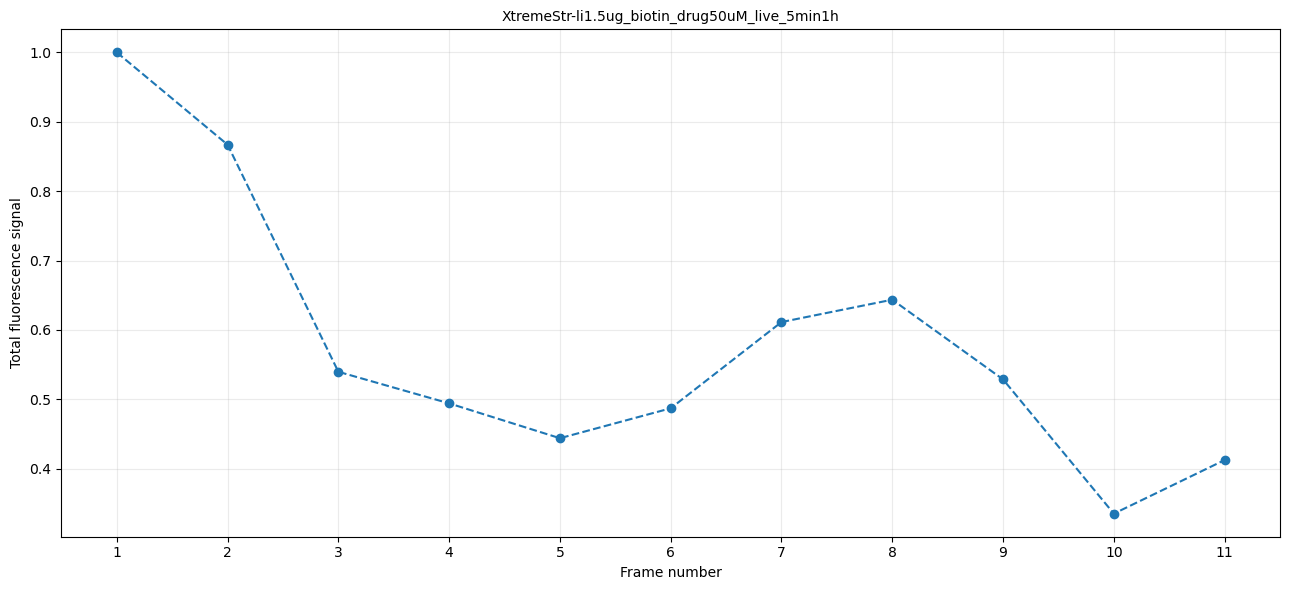

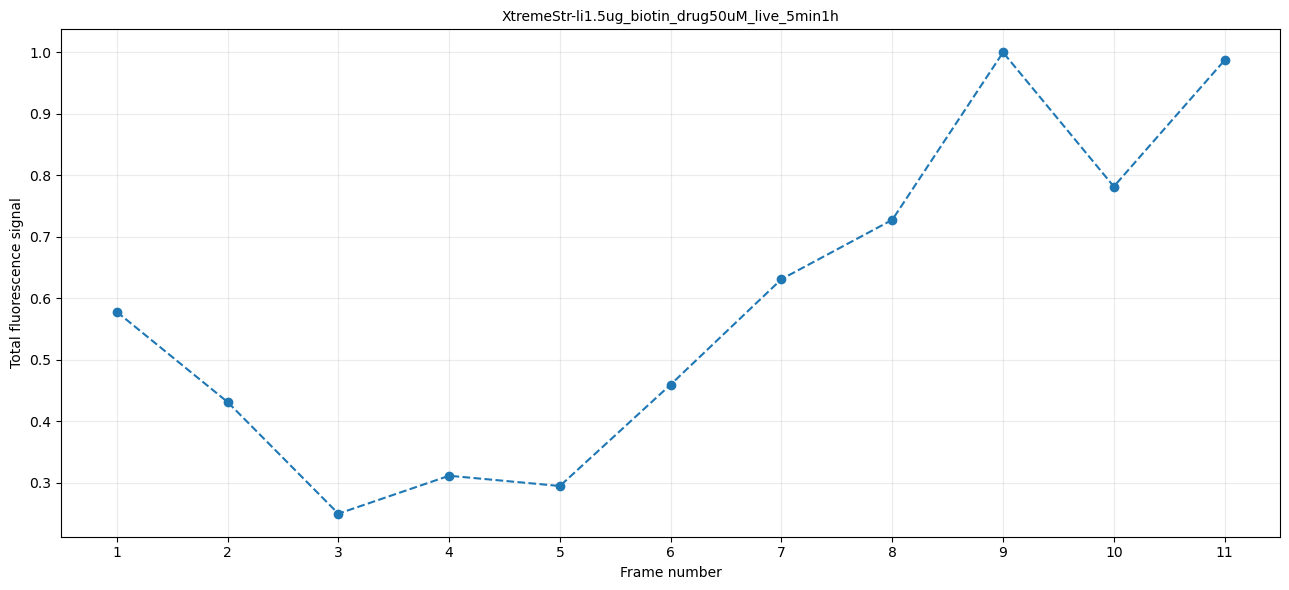

In [50]:
# This works, for our new approach.
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

folders_to_process = ('LipoKDEL1ug_biotin_no drug_live_5min1h',  'LipoKDEL1ug_biotin_drug25uM_live_5min1h', 'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h',
                       '0.5ugDNA_drug10uM_5min45min_1', '0.75ugDNA_drug10uM_5min45min_1', '1ugDNA_drug10uM_5min45min_1')

testing = {'Videos\\0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)],
           'Videos\\0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550)],
           'Videos\\1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300), (695,790, 655,725)],
           'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(25,740, 600,720)],
           'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)],
           'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(85,400, 70,150), (615,675, 650,715), (170,260, 970,1024)]
}
         #   'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min': []
         # }

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path, resolutions): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith('.jpg'): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_grey = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_grey[y1:y2, x1:x2]
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function


def histogrammer(video1, n): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames.
    name = os.path.split(n) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1

    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.

    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    # plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output

for key in testing.keys():
    for i in range(len(testing[key])):
        video1 = extract_fluorescenceData(key, testing[key][i])
        histogrammer(video1, key)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


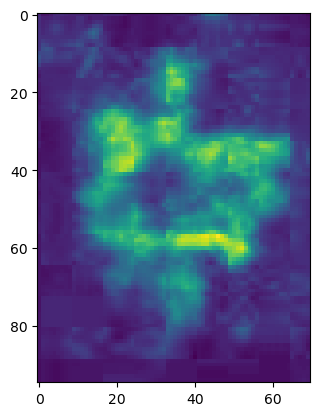

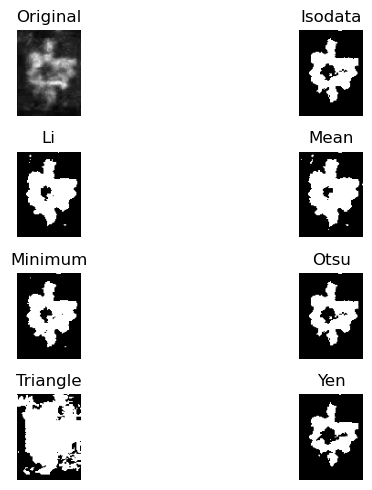

In [17]:
plt.imshow(img_grey)
threshold_all = try_all_threshold(img_grey)

4786.0
---------- Region 0 ----------
Centre	: (48.02611784371082, 33.898035938152944)
Area	: 4786.0


---------- Region 1 ----------
Centre	: (45.727598566308245, 33.473118279569896)
Area	: 279.0




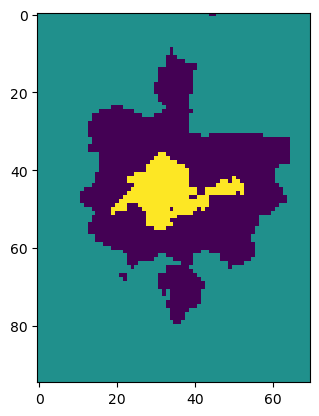

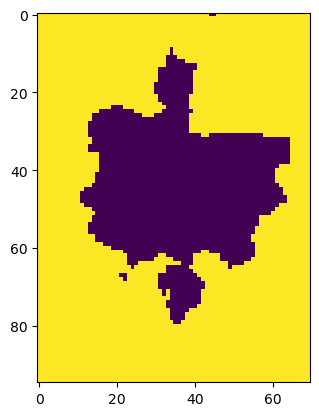

In [38]:
#testing the threshold_minimum chosen for one image
threshold = threshold_yen(img_grey)
img_binarised = img_grey < threshold
# plt.imshow(img_binarised)

img_labelled = measure.label(img_binarised.astype('uint8'))
plt.imshow(img_labelled)

region_info = measure.regionprops(img_labelled)
print(region_info[0].area) # tells you the pixels in a single region

no_of_regions = len(region_info) #only 2 regions present

for count, region in enumerate(region_info):
    print('-'*10, f'Region {count}', '-'*10)
    print(f'Centre\t: {region.centroid}')
    print(f'Area\t: {region.area}')
    print('\n')
plt.show()

img_masked = img_labelled == 1
plt.imshow(img_masked)
plt.show()

In [40]:
def ratio_Data(folder_path, img_order, resolutions):
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path):
                a=plt.imread(img_path)
                img_grey = rgb2gray(a)
                y1, y2, x1, x2 = resolutions
                cropped_img = img_grey[y1:y2, x1:x2]

                try:
                    threshold = threshold_minimum(cropped_img)
                    binarised_img = cropped_img < threshold
                    img_labelled = measure.label(binarised_img.astype('uint8'))
                    region_info = measure.regionprops(img_labelled)
                # plt.imshow(binarised_img, cmap = 'gray')
                # plt.show()

                    total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
                    areas.append((y2-y1)*(x2-x1) - region_info[0].area)
                except RuntimeError:
                    print(f'RuntimeError with {img} image, check for blank images or other problematic data')
                    pass
    else:
        print(f'Subdirectory {video_folders} not found')
    ratio = np.array(total_fluorescence)/np.array(areas)
    return ratio

def overlay_threshold(folder_path, img_order, resolutions):
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration
    y1, y2, x1, x2 = resolutions
    if os.path.exists(os.path.join(subdir_path, img_order[0])):
        first = plt.imread(os.path.join(subdir_path, img_order[0]))
        first = rgb2gray(first)
        first = first[y1:y2,x1:x2] #we could do y2-y1, x2-x1 probably
    overlay = np.zeros(first.shape)

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path):
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                overlay+=cropped_img
                # val, freq = np.unique(cropped_img, return_counts = True)
                # # threshold = val[np.argmax(freq)]
                # threshold = 0.4
                # cropped_img[cropped_img < threshold] = 0

                # total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')

    return extract_Data(folder_path, img_order, resolutions, overlay), overlay

def extract_Data(folder_path, img_order, resolutions, overlay):
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                cropped_img *= overlay
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence


overlay_threshold()

TypeError: overlay_threshold() missing 3 required positional arguments: 'folder_path', 'img_order', and 'resolutions'

# Dr Chamika's playground

In [ ]:
testing = {'Videos\\0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)], 
           'Videos\\0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550)], 
           'Videos\\1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300)], 
           'Videos\\LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(25,740, 600,720)], 
           'Videos\\LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)], 
           'Videos\\XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(85,400, 70,150)]}

def get_label(filepath):
    # x=list(testing.keys())[4]
    label=[fragments for fragments in filepath.split('_') if 'drug' in fragments]
    return label[0].upper()

for key in testing.keys():
    print(get_label(key))

In [ ]:
test = {}
for folder in folder_indexes:
  test[folder] = []
print(test)

# For optimisation

#Definitely need to change this. Just used this to get over the initial hurdle
def extract_frames(video_path, frame_rate=13, output_dir="frames"):
  """Extracts frames from a video file and saves them with unique names.

  Args:
    video_path: The path to the video file.
    frame_rate: The desired frame rate for the extracted frames.
    output_dir: The directory to save the extracted frames.

  Returns:
    A list of extracted frames.
  """

  cap = cv2.VideoCapture(video_path)

  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_interval = frame_count // frame_rate

  frames = []
  for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
      break
    if i % frame_interval == 0:
      frames.append(frame)

  #Create the output directory if it doesn't exist
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  #Save the extracted frames with unique names
  for i, frame in enumerate(frames, start = 1): #indicate starting no.
    filename = f"LipoKDEL1ug_biotin_no drug_live_5min1h_frame_{i:02d}.jpg"  #0 refers to adding leading zeros if needed, and 2 specifies the minimum character in the number which is 2. single digit no. will have leading zeros added to it.
    total_fluorescence.append(img.sum())
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, frame)

  return frames

#Extract frames from the video file
current_directory = os.getcwd()
video_path = os.path.join(current_directory, "LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi")
frames = extract_frames(video_path)

print(f"Extracted {len(frames)} frames.")

# Testing

In [ ]:
print(len(all_video_values))
print(all_video_values)
print(all_video_values[0][0], all_video_values[0][-1])
test = all_video_values[0][0] - all_video_values[0][-1]
print(test) #my shit works bro

In [ ]:
#mid testing. Want to create a function to loop through all the lists inside the list and minus last element with first in each list.
#shits broken af
compiled_rate_change = []

def rate_change(testing):
    rate_changes = []
    for i in range(1, len(all_video_values)):
        rate_change = all_video_values[i][0] - all_video_values[i][-1]/ len(all_video_values)
    rate_changes.append(rate_change)
    return(rate_changes)


test1 = rate_change(all_video_values)
compiled_rate_change.append(test1)
print(compiled_rate_change)

In [ ]:
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, 'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                threshold_o = threshold_otsu(img_gray)
                threshold_y = threshold_yen(img_gray)
                img_gray_otsu = img_gray < threshold_o 
                img_gray_yen = img_gray < threshold_y
                
                # print(img_gray_otsu, img_gray_yen)

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function
    return img_binarised

for i, folder in enumerate(video_folders): #for index inside folder, count the number of folders inside the path video_folders
    video1 = extract_fluorescenceData(folder) #isolate the single videos, split into frames, change to grayscale, give add sum(fluorescence) per frame and save as video1

In [ ]:
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] #using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

def extract_fluorescenceData(folder_path): #creating a function called extract_fluorescenceData, to loop through the 7 different folders.
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd, 'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith(('.jpg')): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                # print(img_gray)
                print(f'Value of threshold_yen {threshold_yen(img_gray)} and value of threshold_otsu {threshold_otsu(img_gray)}')
                # test_y = img.copy(img_gray)
                # test_o = img.copy(img_gray)
                # threshold_y = threshold_yen(img_gray)
                # threshold_o = threshold_otsu(img_gray)
                # test_y[test_y < threshold_y] = 0
                # test_o[test_o < threshhold_o] = 0
                # threshold_y = threshold_yen(img_gray)
                # img_gray_o = img_gray < threshold_otsu 
                # img_gray_y = img_gray < threshold_y
                total_fluorescence.append(img_gray.sum()) #sum up signal inside individual frames and append into total_fluorascence

    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function


def histogrammer(video1, i): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames. 
    name = os.path.split(video_folders[i]) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1
    
    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.
    
    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    # plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output
    

#calling of the functions to do all the dirty work
for i, folder in enumerate(video_folders): #for index inside folder, count the number of folders inside the path video_folders
    video1 = extract_fluorescenceData(folder) #isolate the single videos, split into frames, change to grayscale, give add sum(fluorescence) per frame and save as video1
    all_video_values.append(video1) #append numpy total_fluorescence of this video from each iteration into all_video_values. Placed here instead of extract_fluorescenceData function if not next time i call it, it will append junk
    histogrammer(video1, i) #store the list of fluorescence signals as video1 and plot histogram